In [8]:
import sys
# just needed to find pyLARDA from this location
sys.path.append('../../larda/')

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pyLARDA
import pyLARDA.helpers as h
import datetime

import logging
log = logging.getLogger('pyLARDA')
log.setLevel(logging.CRITICAL)
# log.setLevel(logging.DEBUG)
#log.addHandler(logging.StreamHandler())

from pathlib import Path

In [9]:
%matplotlib inline

In [10]:
import importlib
importlib.reload(pyLARDA)


campaign = 'neumayer_awi'
# campaign = 'coala'

larda = pyLARDA.LARDA('remote', uri='http://larda3.tropos.de')
larda.connect(campaign)

model = 'AIRMASS_SOURCE_FLEX'

AIRMASS_SOURCE_FLEX ['landsfc_below2km', 'landsfc_below5km', 'landsfc_belowmd', 'lat_below2km', 'lat_below5km', 'lat_belowmd', 'precip24', 'region_below2km', 'region_below5km', 'region_belowmd', 'seaice_below2km', 'seaice_v2_below2km']
CLOUDNET ['CLASS', 'CLASS_VOODOO', 'DER', 'DER_S', 'DNC', 'IER', 'IWC', 'LDR', 'LWC', 'LWC_S', 'LWP', 'P', 'T', 'UWIND', 'VEL', 'VWIND', 'WIDTH', 'Z', 'beta', 'depol', 'q', 'rainrate']
CLOUDNET_L1b ['CLASS', 'CLASS_VOODOO', 'DER', 'DER_S', 'DNC', 'IER', 'IWC', 'LDR', 'LWC', 'LWC_S', 'LWP', 'P', 'T', 'UWIND', 'VEL', 'VWIND', 'WIDTH', 'Z', 'beta', 'ceilo_beta', 'ceilo_beta_raw', 'ceilo_beta_smooth', 'depol', 'halo_vel', 'iwv_raw', 'lwp_raw', 'q', 'rainrate']
HATPROg5bin ['BLH', 'BRT', 'CBH', 'HKD_quality', 'HKD_status', 'HPC', 'IRT', 'MET_T', 'MET_p', 'MET_rH', 'TPB', 'TPC', 'iwv', 'lwp']


In [11]:
# get the maximum time range range from server
# for a visualization see http://larda3.tropos.de/?camp=trace_dushanbe&params=AIRMASS_SOURCE_FLEX|region_below2km

import requests

data_rsd2 = requests.get('http://larda3.tropos.de' + '/api/{}/'.format(campaign)).json()

def get_days(data, system, param):
    file_identifier = data['connectors'][system]['params'][param]
    print(file_identifier)
    return data['connectors'][system]['avail'][file_identifier]

days_airmass = get_days(data_rsd2, model, 'landsfc_below2km')

begin_dt = datetime.datetime.strptime(min(days_airmass.keys()), "%Y%m%d") 
end_dt = datetime.datetime.strptime(max(days_airmass.keys()), "%Y%m%d") + datetime.timedelta(hours=24)
print('times on server ', begin_dt, end_dt) 

# however for now manually overwrite it
begin_dt = datetime.datetime(2024, 12, 1)
end_dt = datetime.datetime(2025, 2, 28)

# begin_dt = datetime.datetime(2023, 1, 1)
# end_dt = datetime.datetime(2024, 1, 1)
print('time interval used ', begin_dt, end_dt) 

nc4
times on server  2023-12-25 00:00:00 2025-07-29 00:00:00
time interval used  2024-12-01 00:00:00 2025-02-28 00:00:00


In [12]:
plot_range = [50, 12500]

reception_height = '2km'

airmass_source_ls = larda.read(model, "landsfc_below" + reception_height, [begin_dt,end_dt], plot_range)
airmass_source_ls['var'][airmass_source_ls['var'] < 0] = 0
airmass_source_gn = larda.read(model, "region_below" + reception_height, [begin_dt,end_dt], plot_range)
airmass_source_gn['var'][airmass_source_gn['var'] < 0] = 0

print('filenames loaded ', airmass_source_gn['filename'][:5], '...', airmass_source_gn['filename'][-5:])

try:
    airmass_source_lat = larda.read(model, "lat_below" + reception_height, [begin_dt,end_dt], plot_range)
    print(airmass_source_lat["var_definition"])
    airmass_source_lat['var'][airmass_source_lat['var'] < 0] = 0
    lat_avail = True
    #airmass_source_lat["var_definition"] = {0: '<60', 1: '>60'}   
except:
    lat_avail = False

try:
    # airmass_source_si= larda.read(model, "seaice_below" + reception_height, [begin_dt,end_dt], plot_range)
    airmass_source_si= larda.read(model, "seaice_v2_below" + reception_height, [begin_dt,end_dt], plot_range)
    print(airmass_source_si["var_definition"])
    si_avail = True
    airmass_source_si['var'][airmass_source_si['var'] < 0] = 0
    #airmass_source_lat["var_definition"] = {0: '<60', 1: '>60'}   
    airmass_source_si["var_definition"] = {
        0: 'Water', 1: 'Forest', 2: 'Savanna/shrub', 3: 'Grass/crop', 4: 'Urban', 5: 'Snow/ice', 6: 'Barren', 
        7: 'Sea ice 1..30', 8: 'Sea ice 30..80', 9: 'Sea_ice >80'}
except:
    si_avail = False

print(airmass_source_gn["var_definition"])
if airmass_source_gn["var_definition"][0] == 'cont_europe':
    airmass_source_gn["var_definition"] = {0: 'Europe', 1: 'Sahara', 
                                           2: 'Arabian Peninsula', 3: 'Far East Deserts', 
                                           4: 'Persia', 5: 'India'}
if airmass_source_gn["var_definition"][0] == 'south_america':
    airmass_source_gn["var_definition"] = {0: 'South America', 1: 'Africa', 
                                           2: 'Australia', 3: 'New Zealand', 4: 'Peninsula'}

airmass_source_ls["var_definition"] = {0: 'Water', 1: 'Forest', 
                                       2: 'Savanna/shrubland', 
                                       3: 'Grass/cropland', 
                                       4: 'Urban', 5: 'Snow/ice', 6: 'Barren'}


dt_list = [h.ts_to_dt(t) for t in airmass_source_ls['ts']]
duration_campaign = dt_list[-1] - dt_list[0]
print(duration_campaign)

days_frac = duration_campaign.total_seconds()/(60*60*24)

# if "FLEX" in model:
#     max_time = days_frac*8*500*10*24/3.
#     norm_time = 500*10*24/3.
# else:
#     max_time = days_frac*8*27*10*24/1.
#     norm_time = 27*10*24/1.
    
# print(f'max_time {max_time} ({days_frac*8*500*10*24/3.} {days_frac*8*27*10*24/1.})')
# print('norm_time ', norm_time)

# airmass_source_ls['var'] /= norm_time
# airmass_source_gn['var'] /= norm_time
# if lat_avail:
#     airmass_source_lat['var'] /= norm_time




39kB [00:00, 2.15MB/s]                                                                                                        

filenames loaded  ['/data/level1a/model/trace_airmass_source/neumayer/2024/20241201_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2024/20241202_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2024/20241203_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2024/20241204_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2024/20241205_neumayer_flex-output.nc'] ... ['/data/level1a/model/trace_airmass_source/neumayer/2025/20250224_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2025/20250225_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2025/20250226_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2025/20250227_neumayer_flex-output.nc', '/data/level1a/model/trace_airmass_source/neumayer/2025/20250228_neumayer_flex-output.nc']



.06MB [00:00, 2.40MB/s]                                                                                                       

{0: '<-60', 1: '-60..-30', 2: '-30..0', 3: '0..30', 4: '30..60', 5: '>60'}


1.65MB [00:01, 1.43MB/s]                                                                                                       

{0: 'water', 1: 'forest', 2: 'savanna/shrub', 3: 'grass/crop', 4: 'urban', 5: 'snow', 6: 'barren', 7: 'sea ice 1..30', 8: 'sea ice 30..80', 9: 'sea_ice >90'}
{0: 'south_america', 1: 'africa', 2: 'australia', 3: 'new_zealand', 4: 'peninsula'}
89 days, 0:00:00


In [13]:
def gen_dt_list(start, end, delta=24):
    l = []
    current = start
    while current <= end:
        l.append(current)
        current = current + datetime.timedelta(hours=delta)
    return l

def nearest(point, array):
    """
    searches nearest point in given array and returns (i, value[i])
    taken from BA programm an improved with index calculation
    """
    nearest = min(array[:], key=lambda t: abs(point - t))
    i = np.where(array == nearest)[0][0]
    return (i, nearest)

# trace geonames colors
gn_colors = [(0.65098039215686276, 0.84705882352941175, 0.32941176470588235, 1.0), 
          (1.0, 0.85098039215686272, 0.18431372549019609, 1.0), 
          (0.89803921568627454, 0.7686274509803922, 0.58039215686274515, 1.0),
          (0.40000000000000002, 0.76078431372549016, 0.6470588235294118, 1.0), 
          (0.9882352941176471, 0.55294117647058827, 0.3843137254901961, 1.0), 
          (0.55294117647058827, 0.62745098039215685, 0.79607843137254897, 1.0),  
          (0.70196078431372544, 0.70196078431372544, 0.70196078431372544, 1.0)]

# land surface colors
ls_colors = ['lightskyblue', 'seagreen', 'khaki', '#6edd6e', 'darkmagenta', 'gray', 'tan']

# lat colors
lat_colors = [
    (0.2196078431372549, 0.4235294117647059, 0.6901960784313725, 1.0), #blue
    (0.7450980392156863, 0.6823529411764706, 0.8313725490196079, 1.0), #violet
    (0.9, 0.9, 0.2, 1.0),  # yellow
    (0.7490196078431373, 0.3568627450980392, 0.09019607843137253, 1.0), #brown
    (0.4980392156862745, 0.788235294117647, 0.4980392156862745, 1.0), #green
    (0.5, 0.5, 0.5, 1.0) # grey
            ]
#lat_colors = [matplotlib.cm.get_cmap('Dark2')(i) for i in np.linspace(0,1,6)]

# sea ice colors
si_colors = [
            (0.41, 0.41, 0.41, 1.0), # grey
            (0.0, 0.0, 0.6, 1.0), # darkblue
            (0.2, 0.4, 0.8, 1.0), # blue
            (0.0, 0.6, 1.0, 1.0), # lightblue
            (0.8, 1.0, 1.0, 1.0), # cyan
            (0.8, 0.8, 0.8, 1.0), # grey
            ]

si_colors = ['lightskyblue', 'seagreen', 'khaki', '#6edd6e', 'darkmagenta', 'gray', 'tan',
             (0.2, 0.4, 0.8, 1.0), (0.0, 0.6, 1.0, 1.0), (0.373, 0.588, 0.741, 1.0),]

In [14]:
outpath = 'plots_longterm_neumayer'

Path(outpath).mkdir(exist_ok=True)

[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(90,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(90,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(90,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(90,)


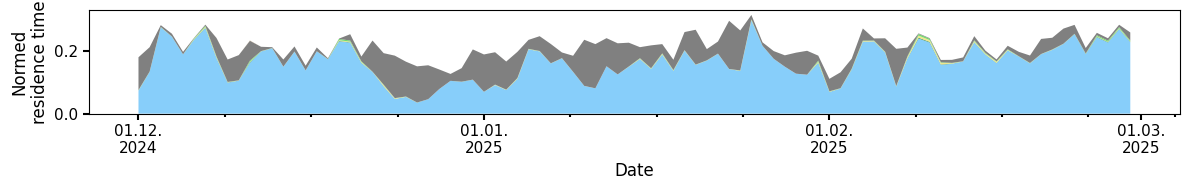

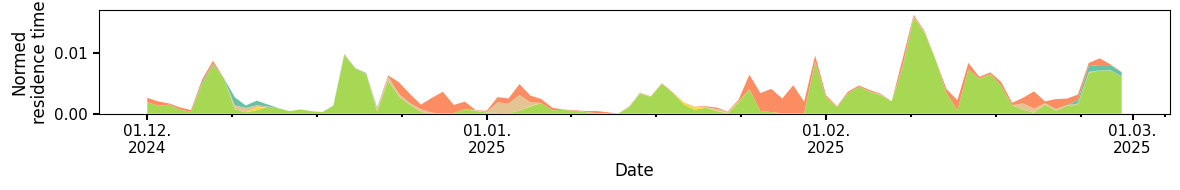

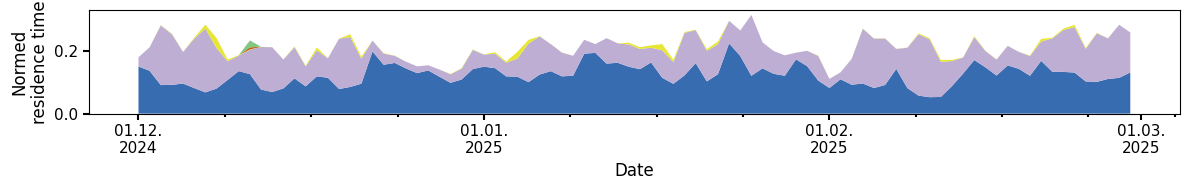

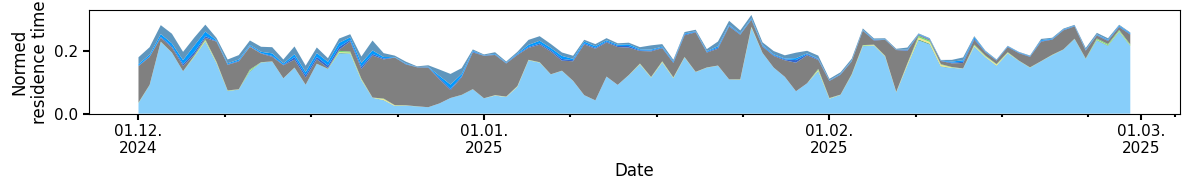

In [15]:
def plot_time_series_stackplot(airmass_source, colors):
    print(airmass_source['rg'])
    dt_subsampled = gen_dt_list(h.ts_to_dt(airmass_source['ts'][0]), h.ts_to_dt(airmass_source['ts'][-1]), delta=24)
    dt_list = [h.ts_to_dt(t) for t in airmass_source['ts']]

    no_categories = airmass_source['var'].shape[2]
    time_series_su = [np.zeros((len(dt_subsampled))) for i in range(no_categories)]


    for it, t in enumerate(dt_subsampled):
        #print('timestep time ', it, t)
        ts = datetime.timedelta(hours=24)
        #print(t-0.5*ts, t+0.5*ts)
        t_start = nearest(h.dt_to_ts(t-0.5*ts), airmass_source['ts'])
        #print(t_start)
        t_end = nearest(h.dt_to_ts(t+0.5*ts), airmass_source['ts'])
        #print(t_end)

        for i in range(no_categories):
            time_series_su[i][it] = np.mean(airmass_source['var'][t_start[0]:t_end[0]+1,:,i])

    print(time_series_su[i].shape)

    fig, ax = plt.subplots(1, figsize=(12, 2))

    ax.stackplot(matplotlib.dates.date2num(dt_subsampled), 
        *time_series_su[:], colors=colors, linewidth=2)
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(bymonthday=[1,]))
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(n=4))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.\n%Y'))

    ax.tick_params(axis='both', which='major', 
                      width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', width=1.5, length=2.5)
    ax.set_ylabel('Normed\nresidence time', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    fig.tight_layout()
    return fig, ax
    
fig, ax = plot_time_series_stackplot(airmass_source_ls, ls_colors)
fname = f'{outpath}/{campaign}_receph{reception_height}_time_series_longterm_stacked'
plt.savefig(fname+'.png', dpi=250)

fig, ax = plot_time_series_stackplot(airmass_source_gn, gn_colors)
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_time_series_longterm_stacked'
plt.savefig(fname+'.png', dpi=250)

if lat_avail:
    fig, ax = plot_time_series_stackplot(airmass_source_lat, lat_colors)
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_time_series_longterm_stacked'
    plt.savefig(fname+'.png', dpi=250)

fig, ax = plot_time_series_stackplot(airmass_source_si, si_colors)
fname = f'{outpath}/{campaign}_receph{reception_height}_si_time_series_longterm_stacked'
plt.savefig(fname+'.png', dpi=250)

[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(713,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(713,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(713,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(713,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000.]
(713,)
[  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500

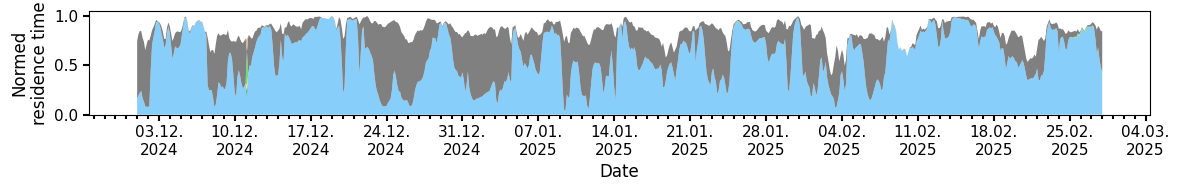

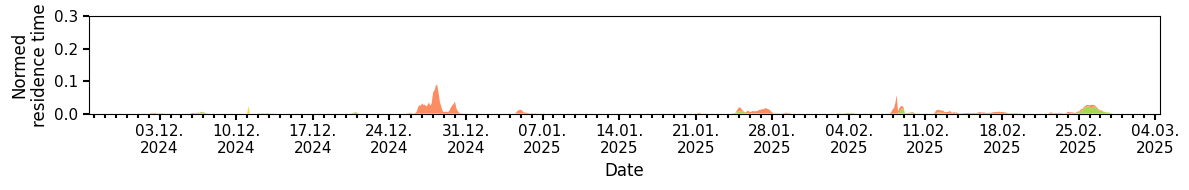

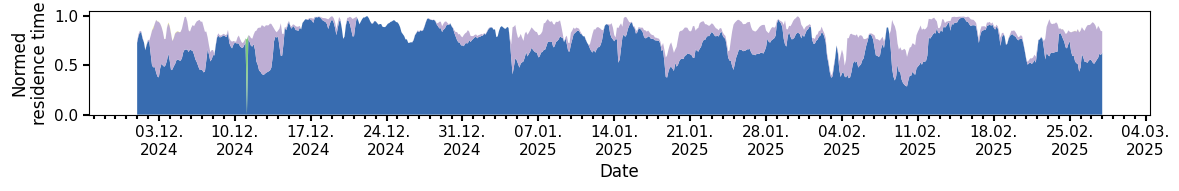

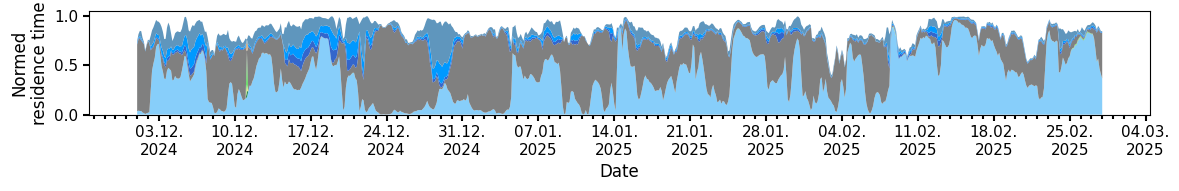

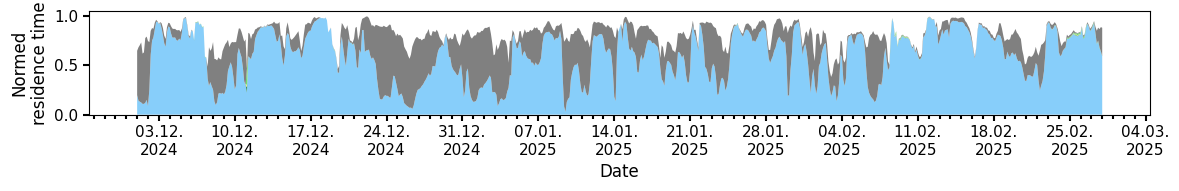

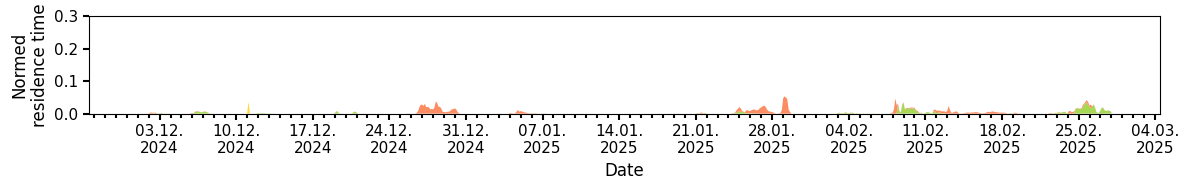

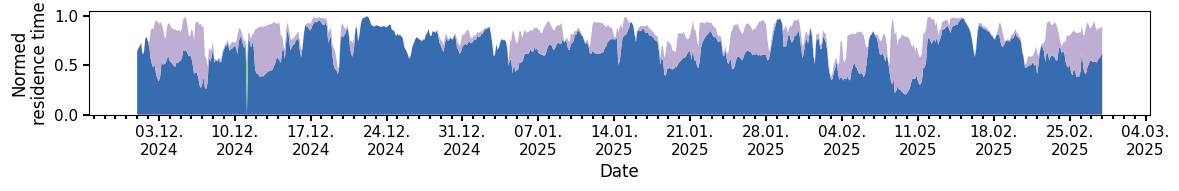

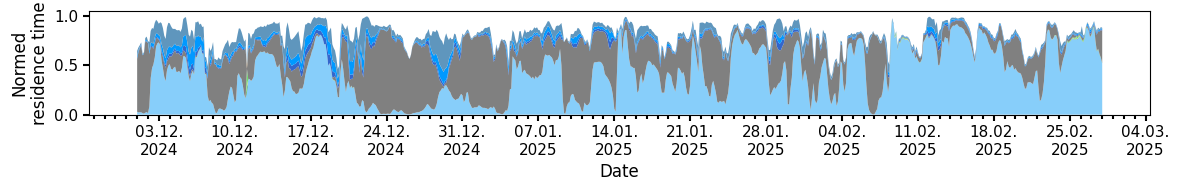

In [16]:
def plot_time_series_lowermost_highres(airmass_source, colors, ih):
    print(airmass_source['rg'])
    dt_list = [h.ts_to_dt(t) for t in airmass_source['ts']]

    no_categories = airmass_source['var'].shape[2]
    time_series_su = [np.zeros((len(dt_list))) for i in range(no_categories)]


    for i in range(no_categories):
        time_series_su[i][:] = airmass_source['var'][:,ih,i]

    print(time_series_su[i].shape)

    fig, ax = plt.subplots(1, figsize=(12, 2))

    ax.stackplot(matplotlib.dates.date2num(dt_list), 
        *time_series_su, colors=colors, linewidth=2)
    # ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(bymonthday=[1,]))
    # ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(n=4))
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.\n%Y'))

    if np.max(airmass_source['var']) < 0.3:
        ax.set_ylim(0,0.3)
    else:
        ax.set_ylim(0,1.05)

    ax.tick_params(axis='both', which='major', 
                      width=1.5, length=4, labelsize=11)
    ax.tick_params(axis='both', which='minor', width=1.5, length=3)
    ax.set_ylabel('Normed\nresidence time', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    fig.tight_layout()
    return fig, ax

ih = 0 
height = airmass_source_ls['rg'][ih]

fig, ax = plot_time_series_lowermost_highres(airmass_source_ls, ls_colors, ih)
fname = f"{outpath}/{campaign}_receph{reception_height}_time_series_hr_stacked_height_{height}m"
plt.savefig(fname+'.png', dpi=250)

fig, ax = plot_time_series_lowermost_highres(airmass_source_gn, gn_colors, ih)
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_time_series_hr_stacked_{height}m'
plt.savefig(fname+'.png', dpi=250)

if lat_avail:
    fig, ax = plot_time_series_lowermost_highres(airmass_source_lat, lat_colors, ih)
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_time_series_hr_stacked_{height}m'
    plt.savefig(fname+'.png', dpi=250)

fig, ax = plot_time_series_lowermost_highres(airmass_source_si, si_colors, ih)
fname = f'{outpath}/{campaign}_receph{reception_height}_si_time_series_hr_stacked_{height}m'
plt.savefig(fname+'.png', dpi=250)

ih = 1
height = airmass_source_ls['rg'][ih]

fig, ax = plot_time_series_lowermost_highres(airmass_source_ls, ls_colors, ih)
fname = f"{outpath}/{campaign}_receph{reception_height}_time_series_hr_stacked_height_{height}m"
plt.savefig(fname+'.png', dpi=250)

fig, ax = plot_time_series_lowermost_highres(airmass_source_gn, gn_colors, ih)
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_time_series_hr_stacked_{height}m'
plt.savefig(fname+'.png', dpi=250)

if lat_avail:
    fig, ax = plot_time_series_lowermost_highres(airmass_source_lat, lat_colors, ih)
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_time_series_hr_stacked_{height}m'
    plt.savefig(fname+'.png', dpi=250)

fig, ax = plot_time_series_lowermost_highres(airmass_source_si, si_colors, ih)
fname = f'{outpath}/{campaign}_receph{reception_height}_si_time_series_hr_stacked_{height}m'
plt.savefig(fname+'.png', dpi=250)

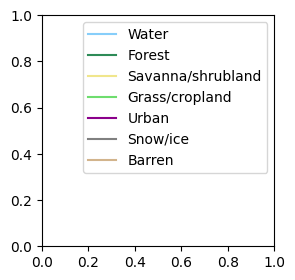

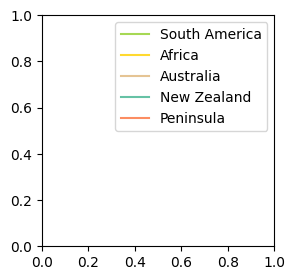

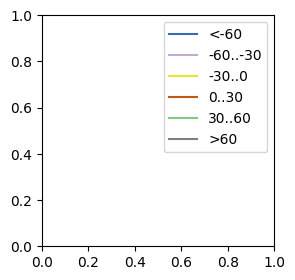

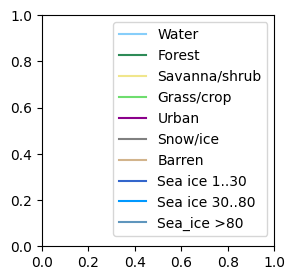

In [17]:
def plot_legend_only(airmass_source, color):

    fig, ax = plt.subplots(figsize=(3,3))
    legend_elements = []
    for i,e in airmass_source['var_definition'].items():
        legend_elements.append(
            matplotlib.lines.Line2D(
                [], [], color=color[i], label=e))
    ax.legend(handles=legend_elements)
    return fig, ax

fig, ax = plot_legend_only(airmass_source_ls, ls_colors)
fname = f'{outpath}/land_surface_class'
plt.savefig(fname+".png", dpi=250)
plt.savefig(fname+".svg", dpi=250)

fig, ax = plot_legend_only(airmass_source_gn, gn_colors)
fname = f'{outpath}/geonames'
plt.savefig(fname+".png", dpi=250)
plt.savefig(fname+".svg", dpi=250)

if lat_avail:
    fig, ax = plot_legend_only(airmass_source_lat, lat_colors)
    fname = f'{outpath}/latitudes'
    plt.savefig(fname+".png", dpi=250)
    plt.savefig(fname+".svg", dpi=250)


if si_avail:
    fig, ax = plot_legend_only(airmass_source_si, si_colors)
    fname = f'{outpath}/sea_ice'
    plt.savefig(fname+".png", dpi=250)
    plt.savefig(fname+".svg", dpi=250)


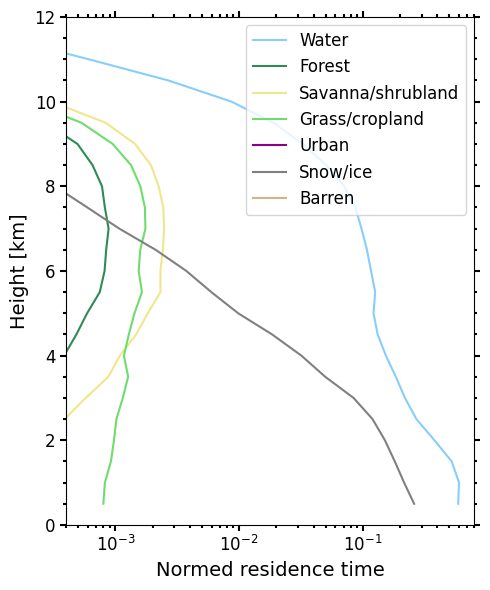

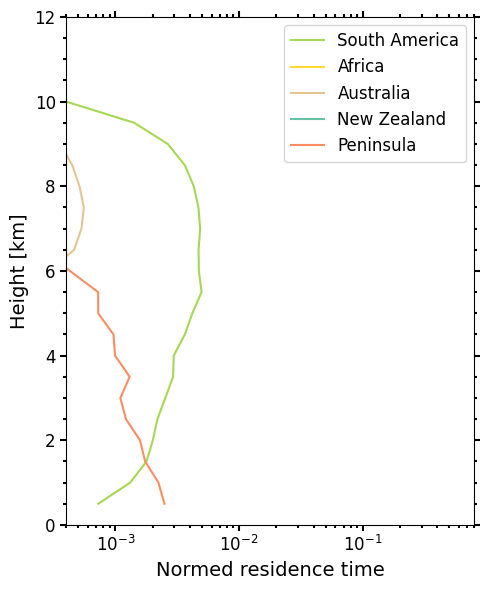

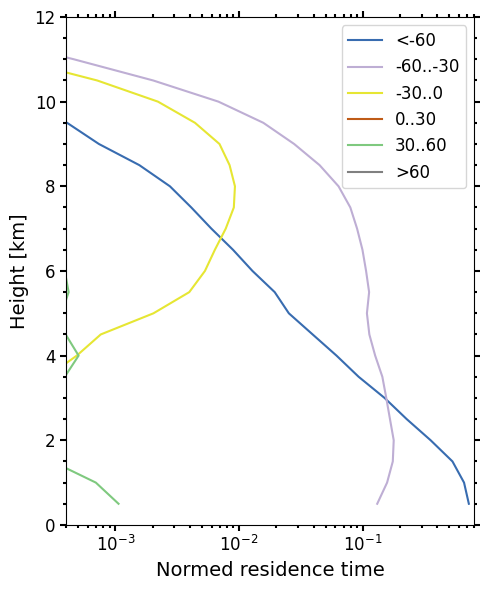

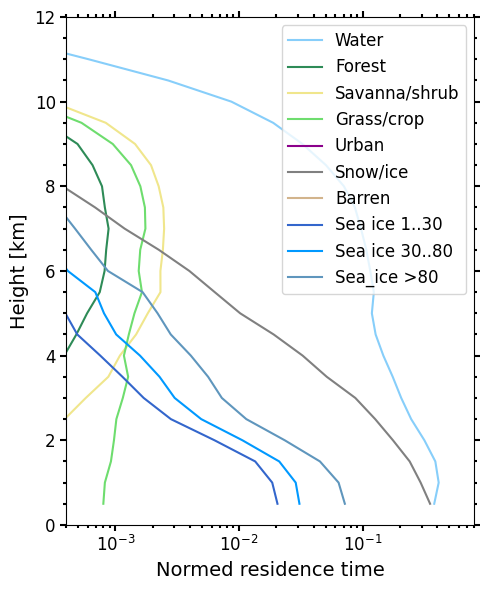

In [18]:
def plot_height_profile(airmass_source, colors, logscale=True):
    height_profiles = []
    no_categories = airmass_source['var'].shape[2]

    for i in range(no_categories):
        height_profiles.append(np.mean(airmass_source['var'][:,:,i], axis=0))

    #height_profile_eur = np.sum(trace_residence_time_combined[:,:,0], axis=0)/1e3


    fig, ax = plt.subplots(figsize=(5, 6))

    for i in range(no_categories):
        ax.plot(height_profiles[i], airmass_source['rg']/1000., 
                label=airmass_source['var_definition'][i],
                color=colors[i], linewidth=1.5)

    ax.set_xlabel('Normed residence time', fontsize=14)
    ax.set_ylabel('Height [km]', fontsize=14)
    ax.set_ylim([0,12])
#     ax.set_xlim([-200,8500])
#     ax.set_xlim([1e3,8.5e6])
#     ax.set_xlim([max_time/2e3, max_time])
    ax.set_xlim([0.0004,0.8])
    
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    if logscale:
        ax.set_xscale('log')
    else:
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=12)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    
    ax.legend(fontsize=12)

    fig.tight_layout()
    return fig, ax

fig, ax = plot_height_profile(airmass_source_ls, ls_colors)   
fname = f'{outpath}/{campaign}_receph{reception_height}_height_profile_longterm'
plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)

fig, ax = plot_height_profile(airmass_source_gn, gn_colors)   
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_height_profile_longterm'
plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)

if lat_avail:
    fig, ax = plot_height_profile(airmass_source_lat, lat_colors)   
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_height_profile_longterm'
    plt.savefig(fname+".png", dpi=250)
    #plt.savefig(fname+".svg", dpi=250)


if si_avail:
    fig, ax = plot_height_profile(airmass_source_si, si_colors)   
    fname = f'{outpath}/{campaign}_receph{reception_height}_si_height_profile_longterm'
    plt.savefig(fname+".png", dpi=250)
    #plt.savefig(fname+".svg", dpi=250)

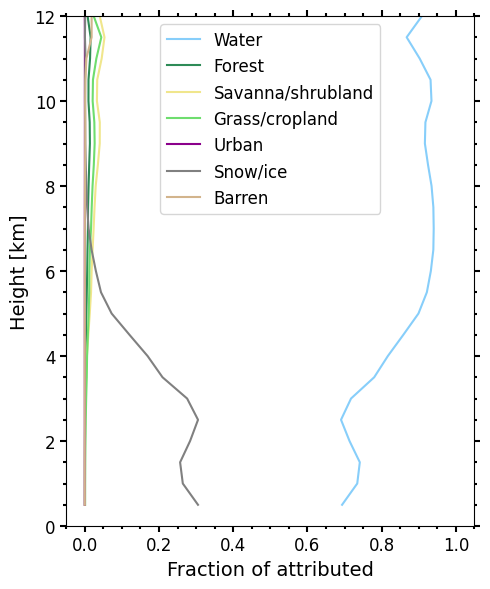

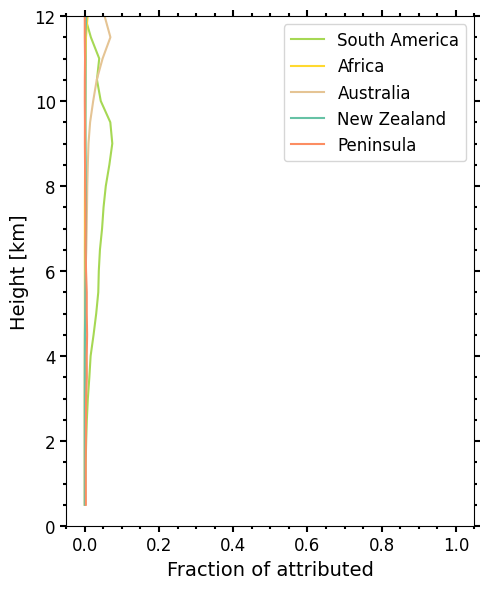

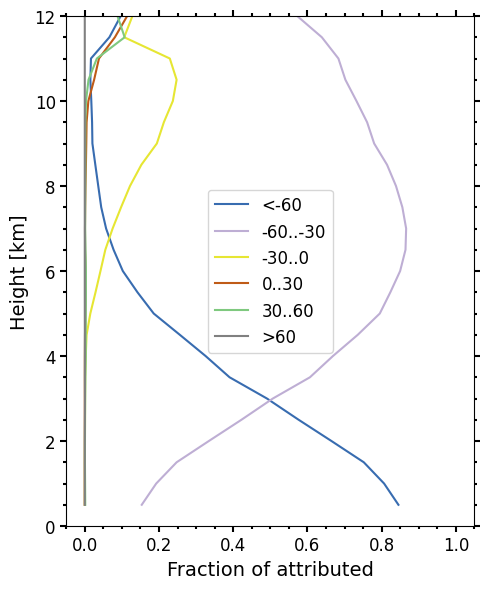

In [19]:
#
# add the relative curves
# 

def plot_height_profile_rel(airmass_source, colors, profile_sum=None, logscale=False):
    height_profiles = []
    no_categories = airmass_source['var'].shape[2]

    if not isinstance(profile_sum, np.ndarray):
        print('Warning: normed by this dataset (take care when interpreting, if not the whole world is covered)')
        profile_sum = np.sum(airmass_source['var'][:,:,:], axis=(0,2))
    for i in range(no_categories):
        height_profiles.append(
            np.sum(airmass_source['var'][:,:,i], axis=0)/profile_sum)

    #height_profile_eur = np.sum(trace_residence_time_combined[:,:,0], axis=0)/1e3

    fig, ax = plt.subplots(figsize=(5, 6))

    for i in range(no_categories):
        ax.plot(height_profiles[i], airmass_source['rg']/1000., 
                label=airmass_source['var_definition'][i],
                color=colors[i], linewidth=1.5)

    ax.set_xlabel('Fraction of attributed', fontsize=14)
    ax.set_ylabel('Height [km]', fontsize=14)
    ax.set_ylim([0,12])
    ax.set_xlim([-0.05,1.05])
#     ax.set_xlim([1e3,8.5e6])
#     ax.set_xlim([max_time/2e3, max_time])

    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    if logscale:
        ax.set_xscale('log')
    else:
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=12)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    
    ax.legend(fontsize=12)

    fig.tight_layout()
    return fig, ax

profile_sum = np.sum(airmass_source_ls['var'][:,:,:], axis=(0,2))
 
fig, ax = plot_height_profile_rel(airmass_source_ls, ls_colors, profile_sum=profile_sum)   
fname = f'{outpath}/{campaign}_receph{reception_height}_height_profile_rel_longterm'
#plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)

fig, ax = plot_height_profile_rel(airmass_source_gn, gn_colors, profile_sum=profile_sum)   
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_height_profile_rel_longterm'
#plt.savefig(fname+".png", dpi=250)
#plt.savefig(fname+".svg", dpi=250)

if lat_avail:
    fig, ax = plot_height_profile_rel(airmass_source_lat, lat_colors, profile_sum=profile_sum)   
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_height_profile_rel_longterm'
    #plt.savefig(fname+".png", dpi=250)
    #plt.savefig(fname+".svg", dpi=250)

[12, 1, 2]  fraction in sample  1.0
[12, 1, 2]  fraction in sample  1.0
[12, 1, 2]  fraction in sample  1.0
[3, 4, 5]  fraction in sample  0.0


/home/radenz/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/radenz/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[3, 4, 5]  fraction in sample  0.0
[3, 4, 5]  fraction in sample  0.0
[6, 7, 8]  fraction in sample  0.0
[6, 7, 8]  fraction in sample  0.0
[6, 7, 8]  fraction in sample  0.0
[9, 10, 11]  fraction in sample  0.0
[9, 10, 11]  fraction in sample  0.0
[9, 10, 11]  fraction in sample  0.0


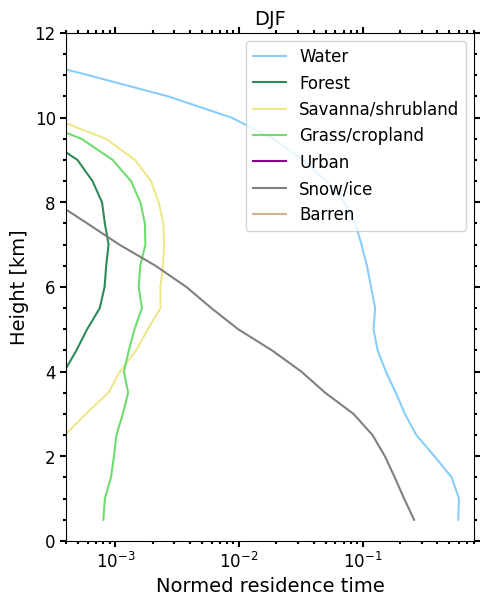

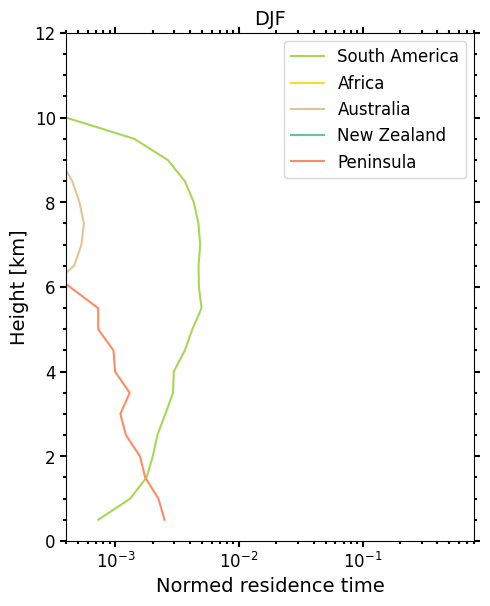

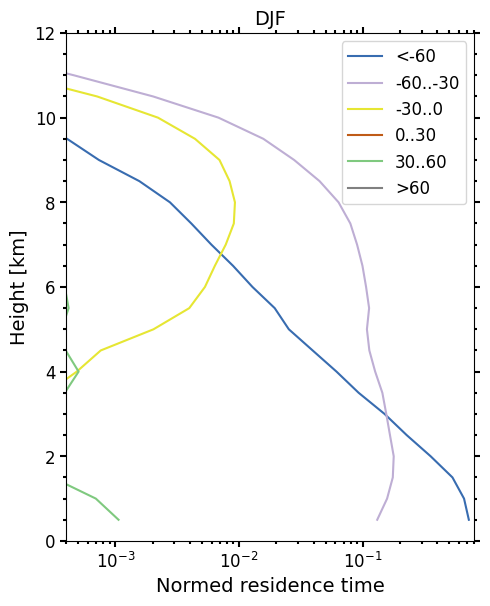

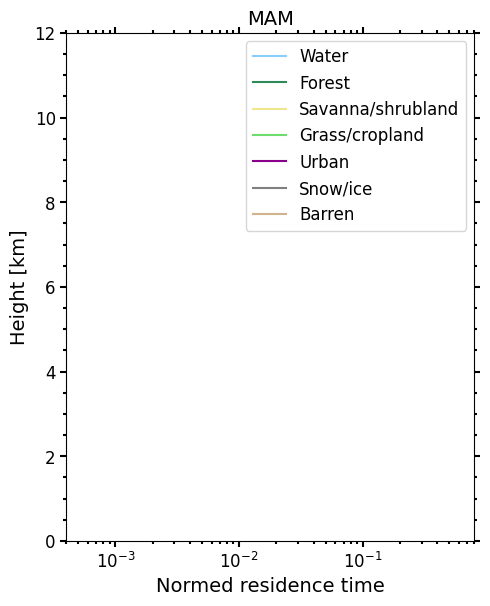

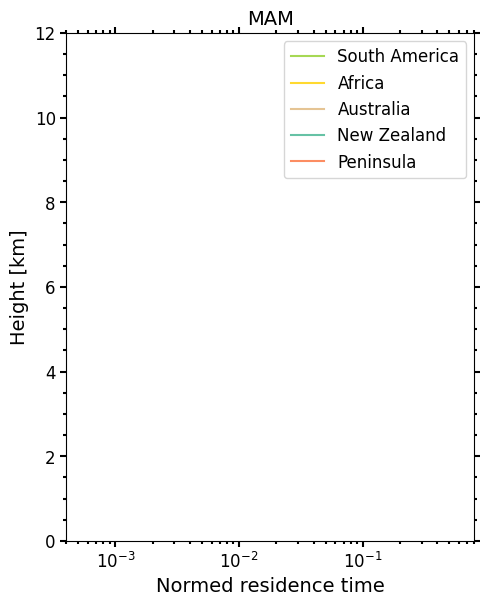

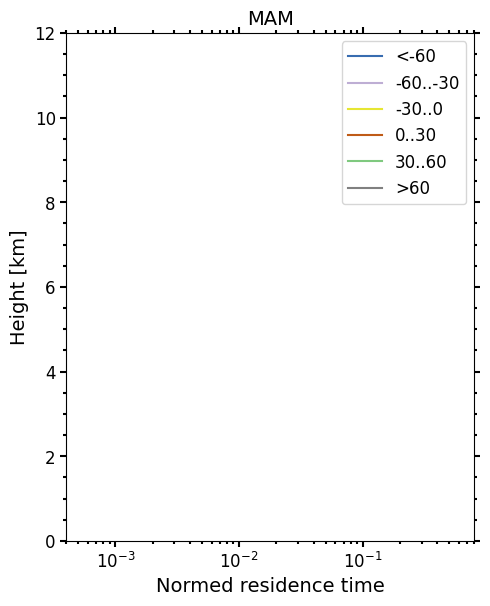

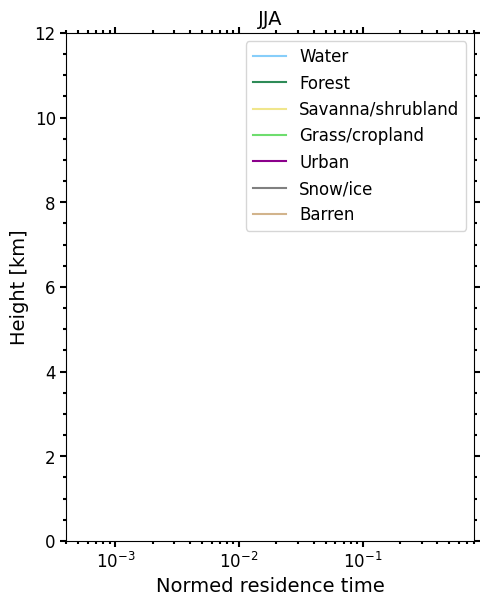

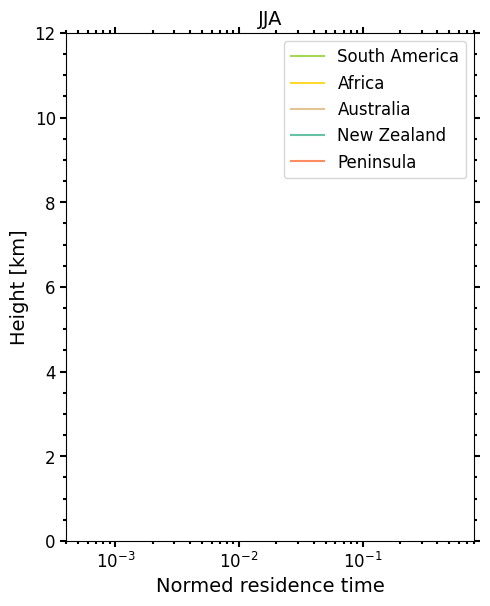

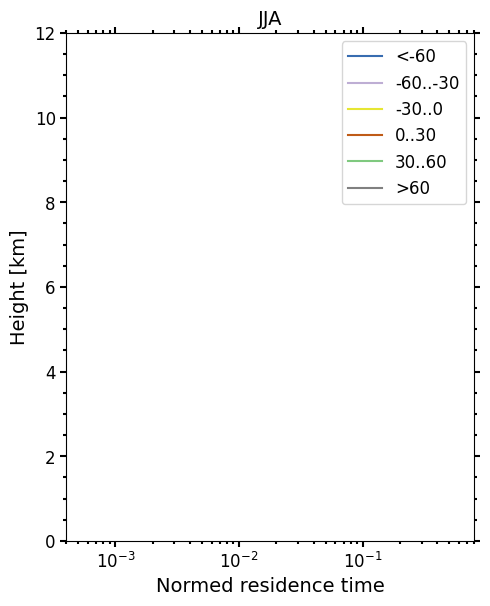

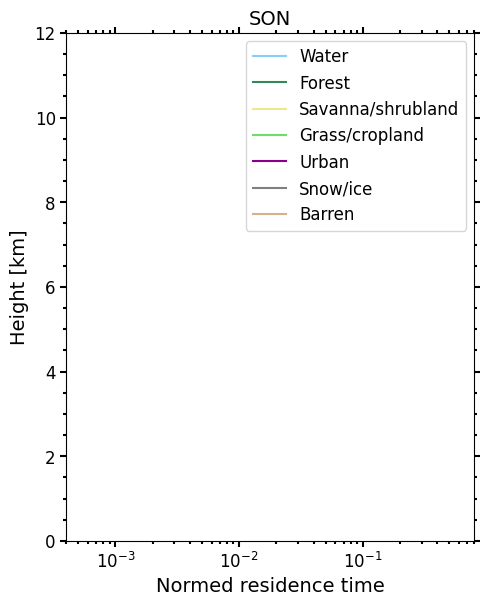

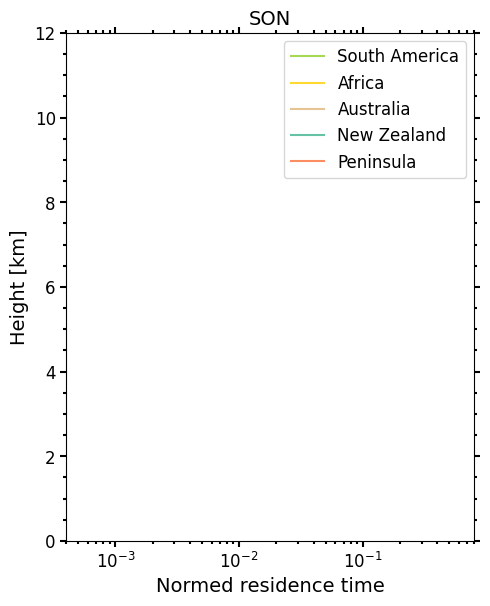

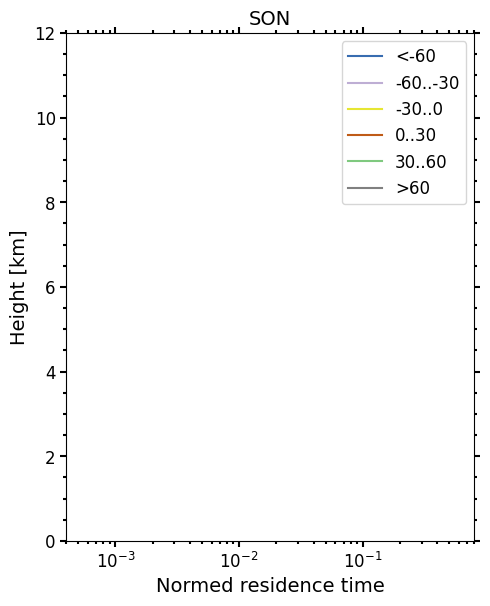

In [20]:
def plot_height_profile_season(airmass_source, colors, months, logscale=True):
    height_profiles = []
    no_categories = airmass_source['var'].shape[2]
    
    dt_list = [h.ts_to_dt(t) for t in airmass_source['ts']]
    season = [dt.month in months for dt in dt_list]
    
    fraction_in_sample = np.sum(season)/len(season)
    print(months, ' fraction in sample ', fraction_in_sample)

    for i in range(no_categories):
        height_profiles.append(np.mean(airmass_source['var'][season,:,i], axis=0))

    fig, ax = plt.subplots(figsize=(5, 6))

    for i in range(no_categories):
        ax.plot(height_profiles[i], airmass_source['rg']/1000., 
                label=airmass_source['var_definition'][i],
                color=colors[i], linewidth=1.5)

    ax.set_xlabel('Normed residence time', fontsize=14)
    ax.set_ylabel('Height [km]', fontsize=14)
    ax.set_ylim([0,12])
#     ax.set_xlim([-200,5000])
#     ax.set_xlim([1e3,5e6])
    ax.set_xlim([0.0004,0.8])
#     # somehow account for the fraction
#     ax.set_xlim([max_time*fraction_in_sample*1.2/2e3, max_time*fraction_in_sample*1.2])

    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    if logscale:
        ax.set_xscale('log')
    else:
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=12)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    ax.legend(fontsize=12)

    fig.tight_layout()
    return fig, ax

#
#
fig, ax = plot_height_profile_season(airmass_source_ls, ls_colors, [12, 1, 2]) 
fname = f'{outpath}/{campaign}_receph{reception_height}_height_profile_DJF'
ax.set_title('DJF', fontsize=14)
plt.savefig(fname+".png", dpi=250)

fig, ax = plot_height_profile_season(airmass_source_gn, gn_colors, [12, 1, 2])   
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_height_profile_DJF'
ax.set_title('DJF', fontsize=14)
plt.savefig(fname+".png", dpi=250)

if lat_avail:
    fig, ax = plot_height_profile_season(airmass_source_lat, lat_colors, [12, 1, 2])   
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_height_profile_DJF'
    ax.set_title('DJF', fontsize=14)
    plt.savefig(fname+".png", dpi=250)

#
#
fig, ax = plot_height_profile_season(airmass_source_ls, ls_colors, [3,4,5]) 
fname = f'{outpath}/{campaign}_receph{reception_height}_height_profile_MAM'
ax.set_title('MAM', fontsize=14)
plt.savefig(fname+".png", dpi=250)

fig, ax = plot_height_profile_season(airmass_source_gn, gn_colors, [3,4,5])   
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_height_profile_MAM'
ax.set_title('MAM', fontsize=14)
plt.savefig(fname+".png", dpi=250)

if lat_avail:
    fig, ax = plot_height_profile_season(airmass_source_lat, lat_colors, [3,4,5])   
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_height_profile_MAM'
    ax.set_title('MAM', fontsize=14)
    plt.savefig(fname+".png", dpi=250)

#
#
fig, ax = plot_height_profile_season(airmass_source_ls, ls_colors, [6,7,8]) 
fname = f'{outpath}/{campaign}_receph{reception_height}_height_profile_JJA'
ax.set_title('JJA', fontsize=14)
plt.savefig(fname+".png", dpi=250)

fig, ax = plot_height_profile_season(airmass_source_gn, gn_colors, [6,7,8])   
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_height_profile_JJA'
ax.set_title('JJA', fontsize=14)
plt.savefig(fname+".png", dpi=250)

if lat_avail:
    fig, ax = plot_height_profile_season(airmass_source_lat, lat_colors, [6,7,8])   
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_height_profile_JJA'
    ax.set_title('JJA', fontsize=14)
    plt.savefig(fname+".png", dpi=250)


#
#
fig, ax = plot_height_profile_season(airmass_source_ls, ls_colors, [9, 10, 11]) 
fname = f'{outpath}/{campaign}_receph{reception_height}_height_profile_SON'
ax.set_title('SON', fontsize=14)
plt.savefig(fname+".png", dpi=250)

fig, ax = plot_height_profile_season(airmass_source_gn, gn_colors, [9, 10, 11])   
fname = f'{outpath}/{campaign}_receph{reception_height}_gn_height_profile_SON'
ax.set_title('SON', fontsize=14)
plt.savefig(fname+".png", dpi=250)

if lat_avail:
    fig, ax = plot_height_profile_season(airmass_source_lat, lat_colors, [9, 10, 11])   
    fname = f'{outpath}/{campaign}_receph{reception_height}_lat_height_profile_SON'
    ax.set_title('SON', fontsize=14)
    plt.savefig(fname+".png", dpi=250)

### Option of Temperature as vertical coordinate

For the Punta Arenas/Limassol/Leipzig studies, i also resampled the airmasses with temperature as vertical coordinate (Paper https://doi.org/10.5194/acp-21-17969-2021 Figure B1).

`missing here`

### Estimate the representativity of the lidar data


<div>
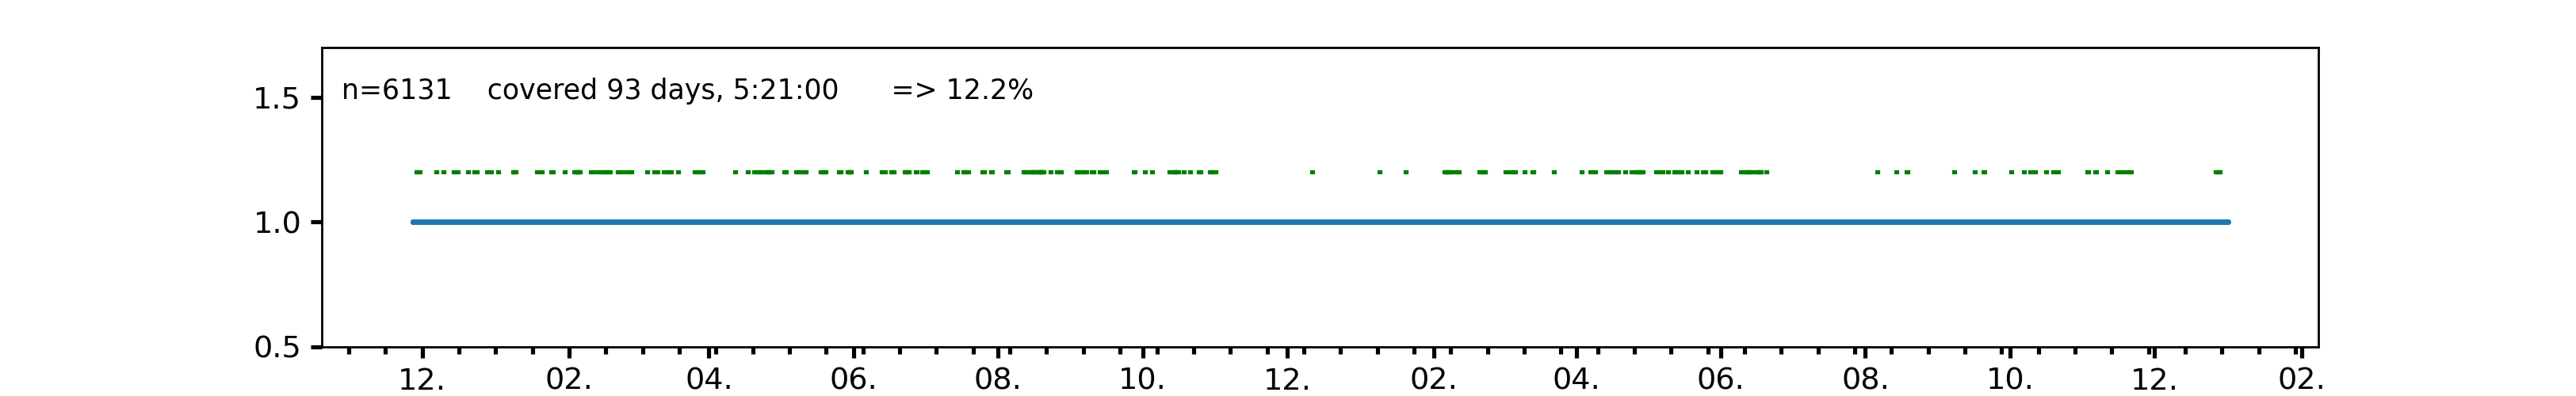
</div>

The example for Punta Arenas shows how airmasses from australia are oversampled below 6.5km and air masses from south america are subsampled between 2 and 6km:

<div>
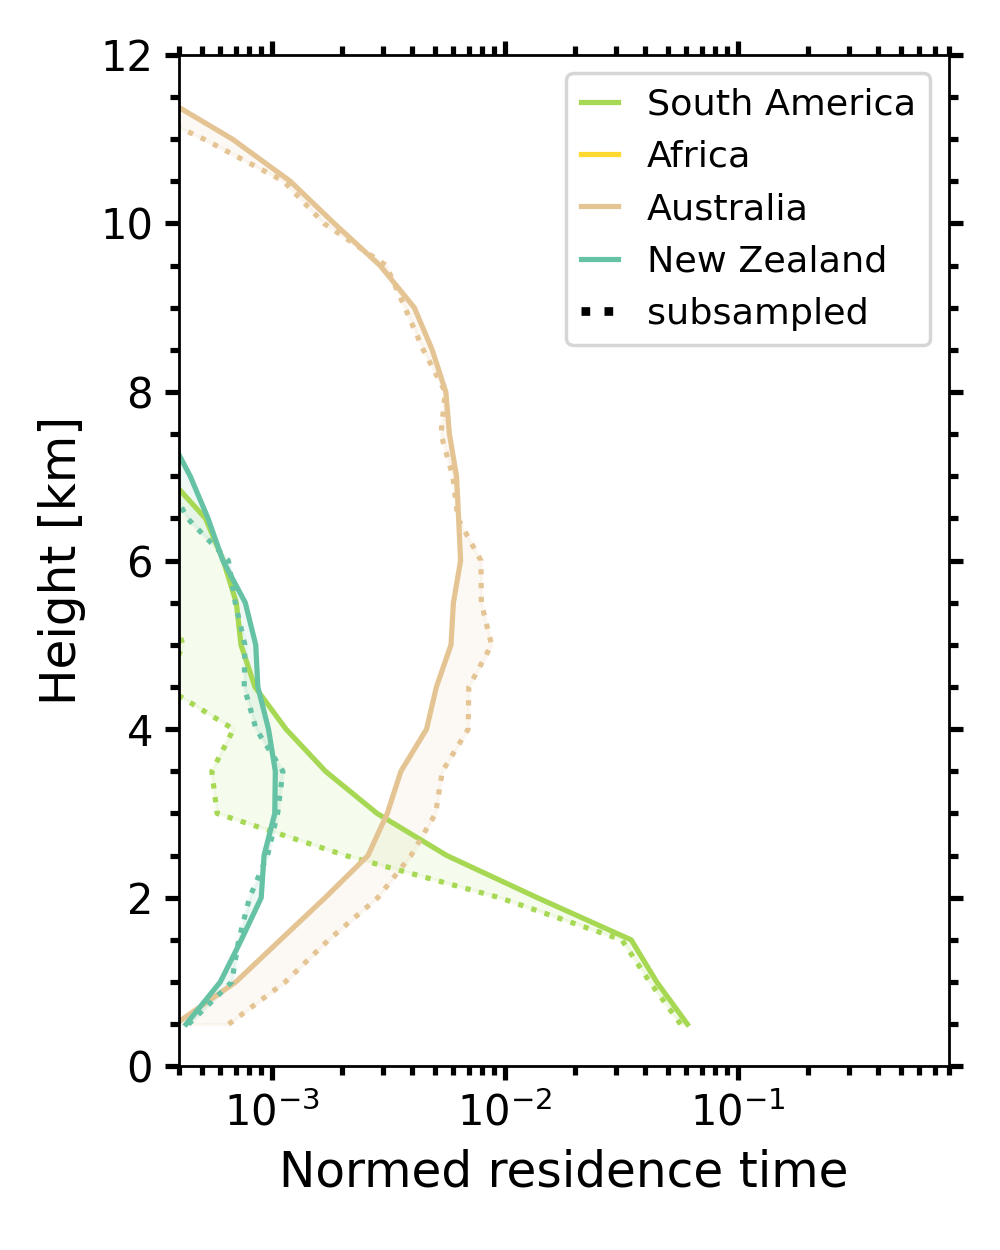
</div>


As a Prerequisite we would net a text file with the periods of the profiles and the top covered

```
20181127_2201;20181127_2300;1049.03515625
20181128_0430;20181128_0528;3325.11669921875
20181128_0822;20181128_0922;9000
```

In [ ]:
if campaign in ['polly_finokalia', 'lacros_hope']:

    print('all profiles ', len(profiles_path))
    

    pathlist = [p for p in profiles_path if p.match(f"*{method}*")]
    print('down to ', len(pathlist))

    dt_covered = []
    for p in pathlist:
        #print(p.name, p.name[5:16], p.name[17:21])
        dt_begin = datetime.datetime.strptime(p.name[5:16], "%y%m%d-%H%M")
        dt_end = datetime.datetime.strptime(p.name[5:11]+p.name[16:21], "%y%m%d-%H%M")
        #print(dt_begin, dt_end)
        dt_covered.append([dt_begin, dt_end])
        
    no_obs = len(pathlist)
        
if campaign == 'lacros_dacapo':
    f = '../2020-08-11_paper_statistics/profiles_times_lacros_dacapo_20181128_20200331.dat'
    f = '../2020-08-11_paper_statistics/profiles_times_lacros_dacapo_20181128_20201231.dat'
    
if campaign == 'lacros_cycare':
    f = '../2020-08-11_paper_statistics/profiles_times_lacros_cycare_20161020_20180325_wo_summer.dat'

if campaign == 'trace_leipzig':
    f = '../2020-08-11_paper_statistics/profiles_times_lacros_leipzig_20140101_20180904.dat'
    
if campaign in ['lacros_dacapo', 'lacros_cycare', 'trace_leipzig']:
    with open(f) as fp: 
        lines = fp.readlines()
        
    dt_covered = []
    for l in lines[:]:
        sbeg, send, htop, _ = l.split(';')
        #print(sbeg, send)
        if float(htop) > 3000:
            dt_covered.append([
                datetime.datetime.strptime(sbeg, "%Y%m%d_%H%M"), 
                datetime.datetime.strptime(send, "%Y%m%d_%H%M")])
            
    no_obs = len(lines)
    print('no_obs ', no_obs, ' times_covered ', len(dt_covered))
            
method = "KLETT"       


In [ ]:


    
    
airmass_source_ls['ts']
def index_nearest(array, left, right, thres):
    """all in ts"""
    i = np.searchsorted(array, [left-thres, right+thres])
    #print(h.ts_to_dt(left), h.ts_to_dt(right))
    if i[0] != i[1]:
        # found inner value
    
        #print(i, list(range(*i)))
        #print(list(map(h.ts_to_dt, array[i])))
        return list(range(*i))
    else:
        return None

def plot_height_profile_special_mask(airmass_source, colors, mask):
    height_profiles = []
    no_categories = airmass_source['var'].shape[2]
    
    dt_list = [h.ts_to_dt(t) for t in airmass_source['ts']]
    
    for i in range(no_categories):
        height_profiles.append(np.mean(airmass_source['var'][mask,:,i], axis=0))

    fig, ax = plt.subplots(figsize=(5, 6))

    for i in range(no_categories):
        ax.plot(height_profiles[i], airmass_source['rg']/1000., 
                label=airmass_source['var_definition'][i],
                color=colors[i], linewidth=2)

    ax.set_xlabel('Normed residence time [h]', fontsize=14)
    ax.set_ylabel('Height [km]', fontsize=14)
    ax.set_ylim([0,12])
    ax.set_xlim([0.0004,0.8])
    ax.set_xscale('log')

    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=12)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    ax.legend(fontsize=12)

    fig.tight_layout()
    return fig, ax


mask = np.zeros_like(airmass_source_ls['ts']).astype(bool)
for left, right in dt_covered:
    i = index_nearest(airmass_source_ls['ts'], 
                      h.dt_to_ts(left), 
                      h.dt_to_ts(right),
                      1.5*60*60)
    if i:
        mask[i] = True
print(mask)


fig, ax = plot_height_profile_special_mask(airmass_source_ls, ls_colors, mask) 
fname = '{}_receph{}_height_profile_polly{}'.format(campaign, reception_height, method)
ax.set_title(f'Polly {method}', fontsize=14)
plt.savefig(fname+".png", dpi=250)


fig, ax = plot_height_profile_special_mask(airmass_source_gn, gn_colors, mask)   
fname = '{}_receph{}_gn_height_profile_polly{}'.format(campaign, reception_height, method)
ax.set_title(f'Polly {method}', fontsize=14)
plt.savefig(fname+".png", dpi=250)

#print(dt_covered)

In [ ]:
duration_profiles = datetime.timedelta(seconds=0)
for left, right in dt_covered:
    duration_profiles += (right-left)

print(duration_profiles)
coverage = duration_profiles.total_seconds()/duration_campaign.total_seconds()
print(coverage)

fig, ax = plt.subplots(figsize=(13, 2))

ax.plot(dt_list, np.ones(len(dt_list)), '.', markersize=2)
for dt_interval in dt_covered:
    ax.plot(dt_interval, [1.2,1.2], color='green')

ax.set_ylim([0.5, 1.7])

#ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d.%m.\n%Y'))
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m.\n%Y'))
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(n=4))
#ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1000))

s = f'n={no_obs}    covered {duration_profiles}      => {coverage*100 :.1f}%'
ax.annotate(s, xy=(0.01, 0.9),  
            xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            )
ax.tick_params(axis='both', which='major', 
              width=1.5, length=4, labelsize=11)
ax.tick_params(axis='both', which='minor', width=1.5, length=2.5)

fname = '{}_timeseries_covered_polly{}'.format(campaign, method)
plt.savefig(fname+".png", dpi=250)

In [ ]:
def plot_height_profile_special_mask_shading(airmass_source, colors, mask, logscale=True):
    height_profiles = []
    height_profiles_full = []
    no_categories = airmass_source['var'].shape[2]
    
    print(np.sum(mask), airmass_source['var'].shape[0])
    fraction = np.sum(mask)/airmass_source['var'].shape[0]
    print(fraction)
    
    dt_list = [h.ts_to_dt(t) for t in airmass_source['ts']]
    
    for i in range(no_categories):
        height_profiles.append(np.mean(airmass_source['var'][mask,:,i], axis=0))
        height_profiles_full.append(np.mean(airmass_source['var'][:,:,i], axis=0))

    fig, ax = plt.subplots(figsize=(5, 6))

    for i in range(no_categories):
        ax.fill_betweenx(airmass_source['rg']/1000.,
                         height_profiles[i], 
                         height_profiles_full[i],
                         color=colors[i], alpha=0.1
                        )
    
    for i in range(no_categories):
        ax.plot(height_profiles[i], airmass_source['rg']/1000., 
                color=colors[i], linewidth=1.5, linestyle=':')
        ax.plot(height_profiles_full[i], airmass_source['rg']/1000.,
                label=airmass_source['var_definition'][i],
                color=colors[i], linewidth=1.5)


#     ax.set_xlabel('Accumulated residence time (adjusted) [h]', fontsize=14)
    ax.set_xlabel('Normed residence time', fontsize=14)
    ax.set_ylabel('Height [km]', fontsize=14)
    ax.set_ylim([0,12])
#     ax.set_xlim([-200,5e6])
#     ax.set_xlim([1e3,5e6])
#     ax.set_xlim([max_time/2e3, max_time])
    ax.set_xlim([0.0004,0.8])

    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    if logscale:
        ax.set_xscale('log')
    else:
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=12)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    
    handles, labels = ax.get_legend_handles_labels()
    
    handles.append(
        matplotlib.lines.Line2D([0], [0], color='black', lw=3, linestyle=":", label='subsampled'))
    print(handles, labels)
    ax.legend(handles=handles, fontsize=12)

    fig.tight_layout()
    return fig, ax

def plot_height_profile_relative(airmass_source, colors, mask):
    height_profiles = []
    height_profiles_full = []
    no_categories = airmass_source['var'].shape[2]
    
    print(np.sum(mask), airmass_source['var'].shape[0])
    fraction = np.sum(mask)/airmass_source['var'].shape[0]
    print(fraction)
    
    dt_list = [h.ts_to_dt(t) for t in airmass_source['ts']]
    
    for i in range(no_categories):
        height_profiles.append(np.mean(airmass_source['var'][mask,:,i], axis=0))
        height_profiles_full.append(np.mean(airmass_source['var'][:,:,i], axis=0))

    fig, ax = plt.subplots(figsize=(5, 6))
    
    ax.axvline(1, color='grey', lw=0.8)
    ax.axvline(2, ls=':', color='grey', lw=0.8)
    ax.axvline(0.5, ls=':', color='grey', lw=0.8)
    for i in range(no_categories):
        ax.plot(height_profiles[i]/height_profiles_full[i], airmass_source['rg']/1000.,
                label=airmass_source['var_definition'][i],
                color=colors[i], linewidth=1.5, linestyle='-')

#     ax.set_xlabel('Accumulated residence time (adjusted) [h]', fontsize=14)
    ax.set_xlabel('Rel sampling', fontsize=14)
    ax.set_ylabel('Height [km]', fontsize=14)
    ax.set_ylim([0,12])
    ax.set_xlim([0.1,10])
    
    if log:
        ax.set_xscale('log')
    else:
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.5))
    
    ax.tick_params(axis='both', which='major', top=True, right=True,
                   width=1.5, length=4, labelsize=12)
    ax.tick_params(axis='both', which='minor', top=True, right=True,
                   width=1.5, length=2.5)
    ax.legend(fontsize=12)

    fig.tight_layout()
    return fig, ax

fig, ax = plot_height_profile_special_mask_shading(airmass_source_ls, ls_colors, mask) 
fname = '{}_receph{}_height_profile_shading_polly{}'.format(campaign, reception_height, method)
# ax.set_title(f'Polly {method}', fontsize=14)
plt.savefig(fname+".png", dpi=250)


fig, ax = plot_height_profile_special_mask_shading(airmass_source_gn, gn_colors, mask) 
fname = '{}_receph{}_gn_height_profile_shading_polly{}'.format(campaign, reception_height, method)
# ax.set_title(f'Polly {method}', fontsize=14)
plt.savefig(fname+".png", dpi=250)

fig, ax = plot_height_profile_special_mask_shading(airmass_source_ls, ls_colors, mask, logscale=False)
fig, ax = plot_height_profile_special_mask_shading(airmass_source_gn, gn_colors, mask, logscale=False) 

fig, ax = plot_height_profile_relative(airmass_source_ls, ls_colors, mask)
fig, ax = plot_height_profile_relative(airmass_source_gn, gn_colors, mask) 

In [ ]:
0.8/2e3